In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os
import h5py

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, DepthwiseConv2D, SeparableConv2D, Input, add, ZeroPadding2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import datasets, layers, models

#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.backend.clear_session()

# pre-processing
train_path = '../../Covid19-dataset/train'
test_path = '../../Covid19-dataset/test'

img_size = 224
batch = 16

# Image loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=10,
                                width_shift_range=10,
                                height_shift_range=10)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(img_size, img_size),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator


train_generator = generate_data(train_path)
test_generator = generate_data(test_path)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Modelling

In [ ]:
# base_model = ResNet50(weights='imagenet', include_top=False,
#                             input_shape=(img_size, img_size,3))

# # freeze extraction layers
# base_model.trainable = False

# # add custom top layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512 , activation='relu')(x)
# predictions = Dense(3, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # confirm unfrozen layers
# for layer in model.layers:
#     if layer.trainable==True:
#         print(layer)


In [ ]:
def conv_block(input_tensor,
               filters,
               kernel_size,
               strides=(2,2)):
    filter_1, filter_2 = filters
    x = SeparableConv2D(filters=filter_1, kernel_size=kernel_size, strides=(1, 1), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=filter_2, kernel_size=kernel_size, strides=strides, activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = SeparableConv2D(filters=filter_3, kernel_size=kernel_size, strides=strides, padding='same')(x)
    shortcut = SeparableConv2D(filters=filter_2, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    x = add([x, shortcut])
    return Activation('relu')(x)

def identity_block(input_tensor,
               filters,
               kernel_size):
    filter_1, filter_2 = filters
    strides = (1, 1)
    x = SeparableConv2D(filters=filter_1, kernel_size=kernel_size, strides=strides, activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=filter_2, kernel_size=kernel_size, strides=strides, activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = SeparableConv2D(filters=filter_3, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = add([x, input_tensor])
    return Activation('relu')(x)

def build_model(input_shape):
    input_img = Input(shape=input_shape, name='ImageInput')
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = conv_block(x, filters=[32, 128], kernel_size=3, strides=(1,1))
    x = identity_block(x, filters=[32, 128], kernel_size=3)
    x = MaxPooling2D((2, 2))(x)
    
    x = conv_block(x, filters=[64, 256], kernel_size=3)
    x = identity_block(x, filters=[64, 256], kernel_size=3)
    
    x = MaxPooling2D((4, 4))(x)
    x = Flatten()(x)
    #     x = identity_block(x, filters=[64, 256], kernel_size=3)
    
#     x = conv_block(x, filters=[128, 256], kernel_size=3)
#     x = identity_block(x, filters=[64, 256], kernel_size=3)
#     x = layers.GlobalMaxPooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

model = build_model(input_shape=(img_size, img_size, 3))

model.summary()    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageInput (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['ImageInput[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 7, 7, 256)   0           ['activation_4[0][0]']           
                                                                                                  
 flatten (Flatten)              (None, 12544)        0           ['max_pooling2d_2[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 512)          6423040     ['flatten[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          65664       ['dropout[0][0]']                
          

## Save our best model during training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

opt = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# Training the Model

In [ ]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = True,
                   callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 20s 1s/step - loss: 1.0060 - accuracy: 0.5378 - val_loss: 1.0959 - val_accuracy: 0.4242
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 0.7581 - accuracy: 0.7689 - val_loss: 1.0896 - val_accuracy: 0.3939
Epoch 3/100
16/16 [==============================] - 19s 1s/step - loss: 0.4911 - accuracy: 0.8327 - val_loss: 1.0789 - val_accuracy: 0.4091
Epoch 4/100
16/16 [==============================] - 19s 1s/step - loss: 0.3659 - accuracy: 0.8526 - val_loss: 1.0738 - val_accuracy: 0.3939
Epoch 5/100
16/16 [==============================] - 18s 1s/step - loss: 0.2955 - accuracy: 0.8805 - val_loss: 1.0634 - val_accuracy: 0.3939
Epoch 6/100
16/16 [==============================] - 19s 1s/step - loss: 0.2877 - accuracy: 0.8685 - val_loss: 1.0508 - val_accuracy: 0.3939
Epoch 7/100
16/16 [==============================] - 19s 1s/step - loss: 0.2526 - accuracy: 0.9084 - val_loss: 1.0463 - val_accuracy: 0.3939
Epoch 8/100
1

# Evaluation

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

model = load_model('./model.hdf5')

def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

### Loading our best model

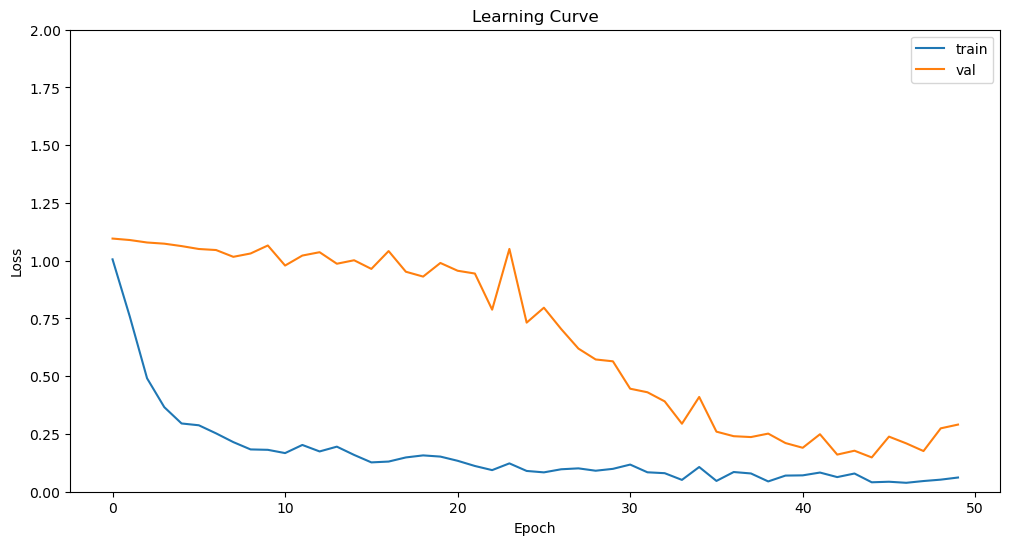

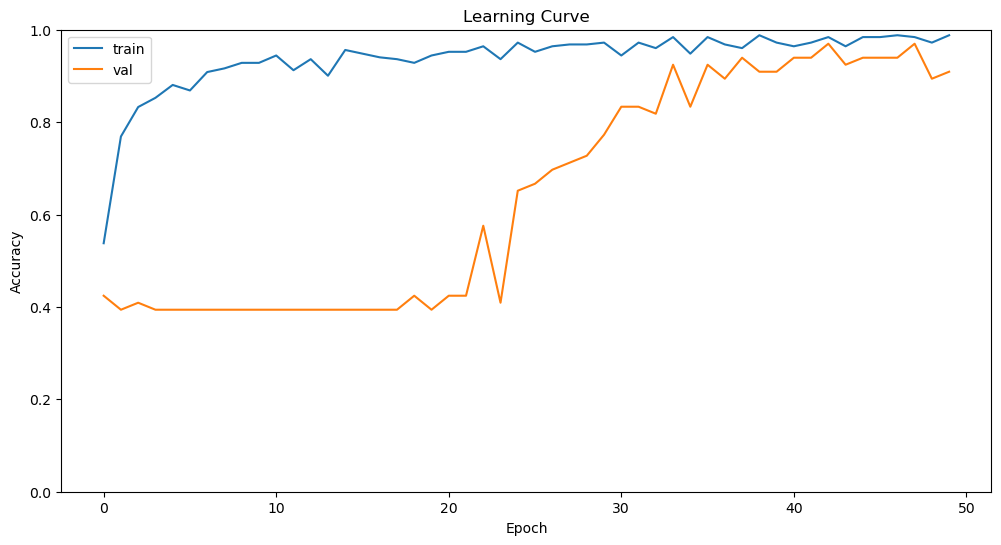

In [ ]:
learning_curve(history,'loss', ylim=(0,2))
learning_curve(history, 'accuracy', ylim=(0,1))

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

5/5 [==============================] - 2s 394ms/step - loss: 0.1962 - accuracy: 0.9545
Loss: 19.617
Accuracy: 95.455
